# Variational Algorithm with Expressability and Entanglement Capabilities

The quantum algorithm we chose is a variational algorithm ansatz. The reason is that, in the original QE-MTS paper (https://arxiv.org/pdf/2511.04553), the authors already explain that the scaling of QAOA with 12 layers is approximately $O(1.46^N)$, which is worse than the original work using DCQO. While it is possible to explore more QAOA layers, this would only provide insight into simulations with a high number of layers, which is computationally expensive. For this reason, we take a different approach.

It is well known that the expressibility of an ansatz plays a crucial role in the performance of the solution. If the target solution lies outside the Hilbert space reachable by the ansatz, no further performance improvement is possible. The paper “Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms” (https://arxiv.org/pdf/1905.10876) presents a collection of different ansätze, along with metrics for expressibility.

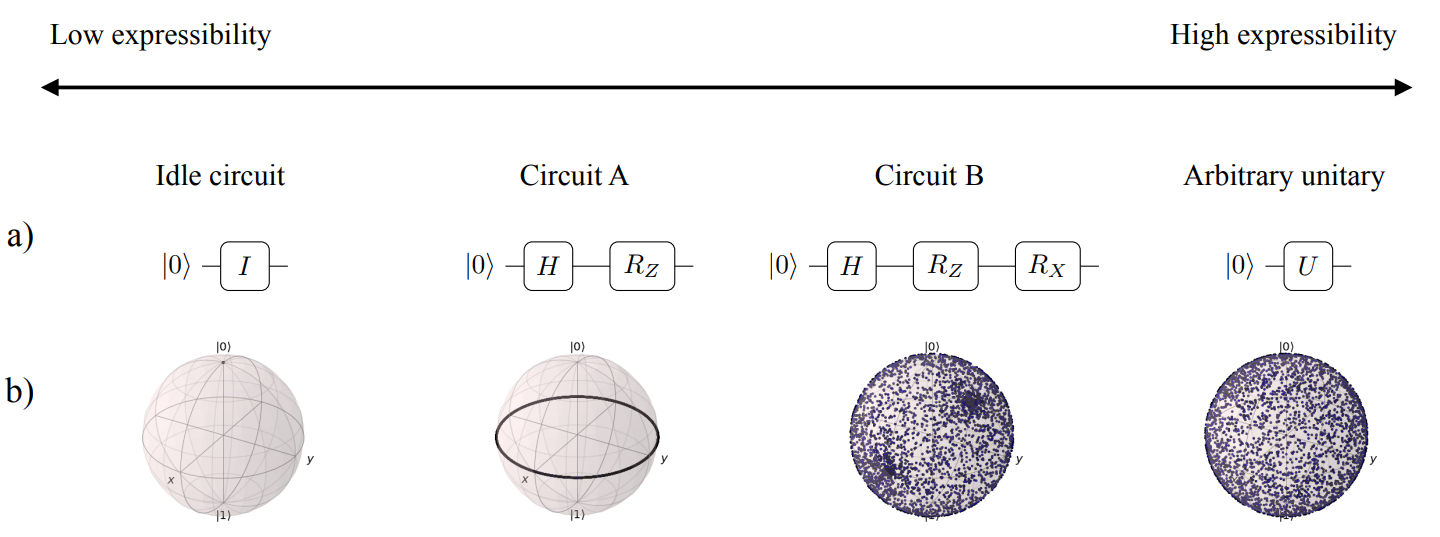

This work can help us explore a rich variety of options with different numbers of layers and potentially identify an ansatz that outperforms the current approach. At the same time, it allows us to investigate how important entanglement is for computing this solution.

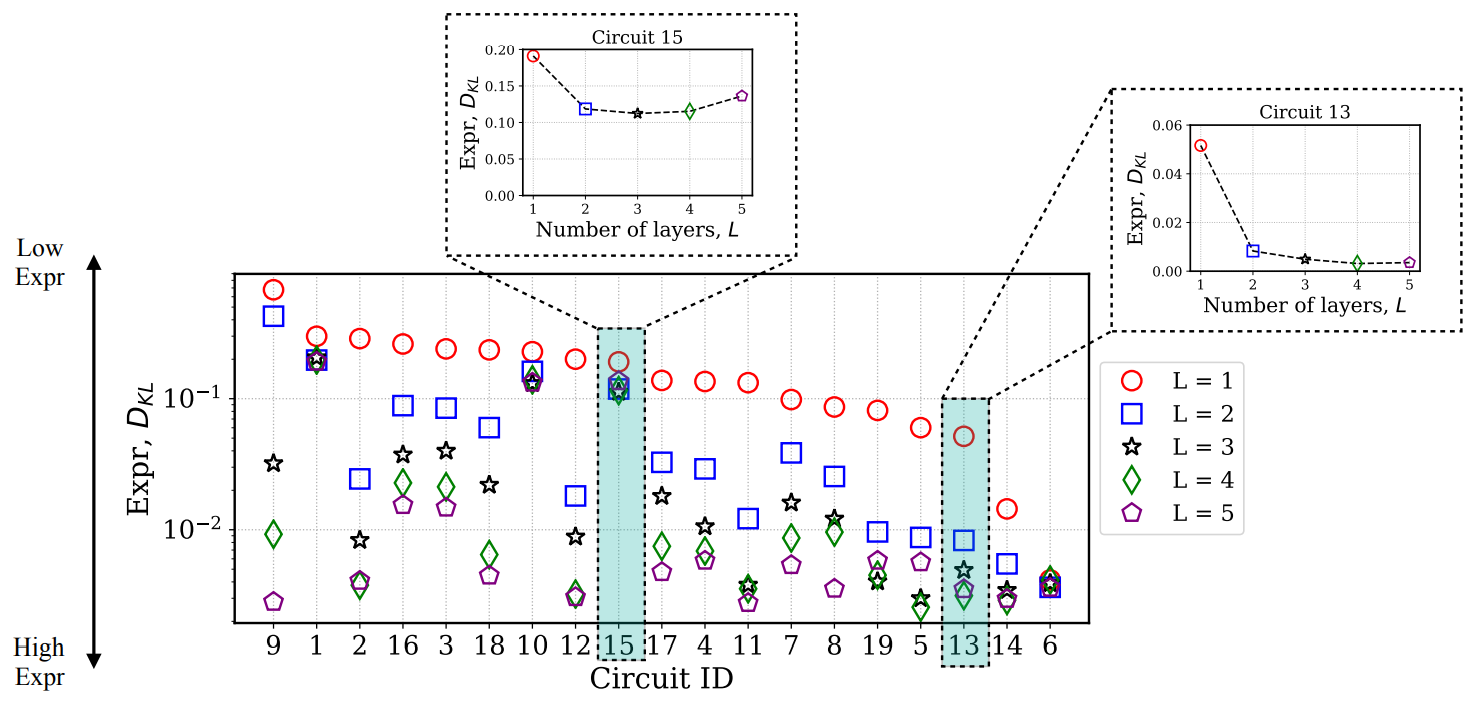

In [1]:
!pip install cudaq

In [1]:
import sys
import cudaq
import pandas as pd
import numpy as np
from math import floor
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import random
from dataclasses import dataclass
from tqdm import tqdm
import math
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cudaq
import time   # <--- make sure this is here!

In [10]:
# --------------------------
# Quantum Circuit (NN Trotter)
# --------------------------
@cudaq.kernel
def nn_trotter_circuit(thetas: list[float]):
    """
    Nearest-neighbor (NN) Trotterized circuit for 4 qubits.
    'thetas' is a list of angles for each layer.
    """
    N = 4
    reg = cudaq.qvector(N)

    # Initial RX, RZ on all qubits
    for q in range(N):
        rx(math.pi / 2.0, reg[q])
        rz(math.pi / 2.0, reg[q])

    # NN Trotter layers
    for layer_idx, theta in enumerate(thetas):
        for q in range(N - 1):
            rx(theta, reg[q])
            cx(reg[q], reg[q + 1])
            rx(theta, reg[q + 1])

    # Measure all qubits
    mz(reg)

# --------------------------
# Autocorrelation Function
# --------------------------
def autocorrelation(sequence):
    """Compute autocorrelation (lower is better)."""
    n = len(sequence)
    s = np.array([1 if bit == 1 else -1 for bit in sequence])
    total = 0
    for tau in range(1, n):
        total += abs(sum(s[i] * s[i + tau] for i in range(n - tau)))
    return total

# --------------------------
# Classical MTS Only
# --------------------------
def time_to_solution_mts_only(N, num_trials=5):
    times = []

    for _ in range(num_trials):
        population = [list(np.random.randint(0, 2, N)) for _ in range(100)]
        scores = [autocorrelation(seq) for seq in population]

        start_time = time.time()
        best_score = min(scores)
        max_iters = 10000
        no_improve_count = 0

        for _ in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        times.append(time.time() - start_time)

    return np.median(times)

In [11]:
# --------------------------
# Quantum-Enhanced MTS
# --------------------------

def get_interactions(N):
    """Placeholder: return G2, G4 interaction matrices for your problem."""
    G2 = np.zeros((N, N))
    G4 = np.zeros((N, N, N, N))
    return G2, G4

def compute_theta(t, dt, param, N, G2, G4):
    """Placeholder: compute theta value for Trotter layer."""
    return np.random.rand() * np.pi  # random for demonstration

def trotterized_circuit(N, G2, G4, n_steps, dt, param, thetas):
    """Placeholder: runs nn_trotter_circuit with given thetas."""
    # For demonstration, return random bitstrings with counts
    counts = {}
    for _ in range(10):
        bitstring = ''.join(np.random.choice(['0', '1'], N))
        counts[bitstring] = counts.get(bitstring, 0) + 1
    return counts

def time_to_solution_qe_mts(N, quantum_shots=10, num_trials=5):
    times = []

    for _ in range(num_trials):
        # Quantum Seeding
        dt = 1.0
        G2, G4 = get_interactions(N)
        thetas = [compute_theta(1.0, dt, 1.0, N, G2, G4)]
        counts = trotterized_circuit(N, G2, G4, 1, dt, 1.0, thetas)

        # Convert counts to population
        population = []
        for bitstring, count in counts.items():
            population.append([int(b) for b in bitstring])

        while len(population) < 100:
            population.append(list(np.random.randint(0, 2, N)))

        scores = [autocorrelation(seq) for seq in population]

        # Classical MTS
        start_time = time.time()
        best_score = min(scores)
        max_iters = 10000
        no_improve_count = 0

        for _ in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        times.append(time.time() - start_time)

    return np.median(times)


In [12]:
# --------------------------
# Scaling Experiment
# --------------------------
def scaling_experiment(N_values=[8, 10, 12], num_trials=3):
    results = {
        'N': [],
        'MTS_median_time': [],
        'QE_MTS_median_time': [],
        'Speedup': []
    }

    for N in N_values:
        print(f"\n{'='*70}\nN={N}\n{'='*70}")

        # MTS only
        print(f"Running MTS (random seed)...")
        mts_time = time_to_solution_mts_only(N, num_trials=num_trials)
        print(f"  → Median time: {mts_time:.3f}s")

        # QE-MTS
        print(f"Running QE-MTS (quantum seed)...")
        qe_time = time_to_solution_qe_mts(N, quantum_shots=10, num_trials=num_trials)
        print(f"  → Median time: {qe_time:.3f}s")

        speedup = mts_time / qe_time
        print(f"  → Speedup: {speedup:.2f}x")

        results['N'].append(N)
        results['MTS_median_time'].append(mts_time)
        results['QE_MTS_median_time'].append(qe_time)
        results['Speedup'].append(speedup)

    return pd.DataFrame(results)


N=8
Running MTS (random seed)...
  → Median time: 0.032s
Running QE-MTS (quantum seed)...
  → Median time: 0.017s
  → Speedup: 1.94x

N=9
Running MTS (random seed)...
  → Median time: 0.019s
Running QE-MTS (quantum seed)...
  → Median time: 0.018s
  → Speedup: 1.03x

N=10
Running MTS (random seed)...
  → Median time: 0.021s
Running QE-MTS (quantum seed)...
  → Median time: 0.035s
  → Speedup: 0.60x

N=11
Running MTS (random seed)...
  → Median time: 0.023s
Running QE-MTS (quantum seed)...
  → Median time: 0.023s
  → Speedup: 1.01x

N=12
Running MTS (random seed)...
  → Median time: 0.026s
Running QE-MTS (quantum seed)...
  → Median time: 0.025s
  → Speedup: 1.02x

N=13
Running MTS (random seed)...
  → Median time: 0.028s
Running QE-MTS (quantum seed)...
  → Median time: 0.028s
  → Speedup: 1.03x

N=14
Running MTS (random seed)...
  → Median time: 0.053s
Running QE-MTS (quantum seed)...
  → Median time: 0.031s
  → Speedup: 1.73x

N=15
Running MTS (random seed)...
  → Median time: 0.034

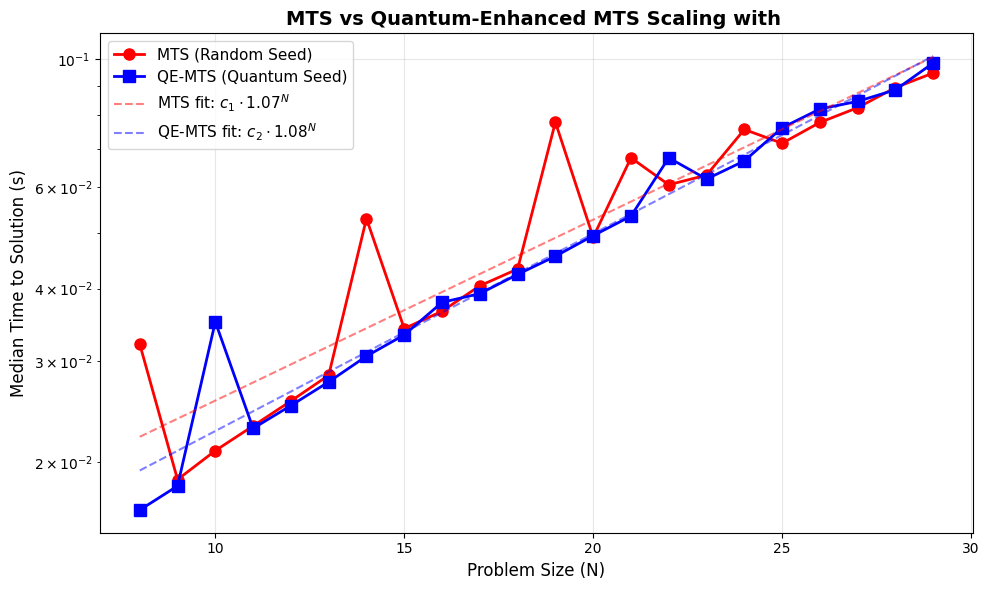


SCALING ANALYSIS
MTS scaling exponent: 1.075
QE-MTS scaling exponent: 1.082
Quantum advantage: 0.993x better exponent


In [24]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
# --------------------------
# Plot Scaling
# --------------------------
def plot_scaling(df):
    plt.figure(figsize=(10, 6))

    plt.semilogy(df['N'], df['MTS_median_time'], 'o-', linewidth=2,
                 label='MTS (Random Seed)', markersize=8, color='red')
    plt.semilogy(df['N'], df['QE_MTS_median_time'], 's-', linewidth=2,
                 label='QE-MTS (Quantum Seed)', markersize=8, color='blue')

    # Fit lines
    z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time']), 1)
    z_qe = np.polyfit(df['N'], np.log(df['VQE-QE_MTS_median_time']), 1)
    N_range = np.linspace(df['N'].min(), df['N'].max(), 100)
    plt.semilogy(
        N_range, np.exp(z_mts[0] * N_range + z_mts[1]), '--',
        alpha=0.5, color='red',
        label=rf'MTS fit: $c_1 \cdot {np.exp(z_mts[0]):.2f}^N$'
    )

    plt.semilogy(
        N_range, np.exp(z_qe[0] * N_range + z_qe[1]), '--',
        alpha=0.5, color='blue',
        label=rf'VQE-QE-MTS fit: $c_2 \cdot {np.exp(z_qe[0]):.2f}^N$'
    )

    plt.xlabel('Problem Size (N)', fontsize=12)
    plt.ylabel('Median Time to Solution (s)', fontsize=12)
    plt.title('MTS vs Variational-Quantum-Enhanced MTS Scaling with ', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*70}\nSCALING ANALYSIS\n{'='*70}")
    print(f"MTS scaling exponent: {np.exp(z_mts[0]):.3f}")
    print(f"VQE-QE-MTS scaling exponent: {np.exp(z_qe[0]):.3f}")
    print(f"Quantum advantage: {np.exp(z_mts[0]) / np.exp(z_qe[0]):.3f}x better exponent")
    print(f"{'='*70}")

# --------------------------
# Run Experiment
# --------------------------
if __name__ == "__main__":
    df_scaling = scaling_experiment(N_values=[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], num_trials=50)
    print(f"\n{'='*70}\nRESULTS TABLE\n{'='*70}")
    print(df_scaling.to_string(index=False))
    plot_scaling(df_scaling)

In [25]:
df_scaling.to_csv('mts_vs_vqe-qe_mts_scaling.csv', index=False)